Trabalho 2 — PGA para Coloração de Grafos (GCP)

Implementação em **Python** do algoritmo do artigo base “Parallel Genetic Algorithm for Graph Coloring Problem”
com:
- Operadores: SPPX, CEX, GPX, UISX
- Mutação: First Fit e Transposition
- Modelo de migração (ilhas)
- Experimentos: repetição, estatísticas, tabelas e gráficos

In [1]:
import sys
print(sys.executable)

c:\Users\marce\OneDrive - Universidade Federal de Uberlândia\Área de Trabalho\IC\aplicacao-algoritmosGeneticos-inteligenciaComp_2025-2\aplicacao-algoritmosGeneticos-inteligenciaComp_2025-2\.venv\Scripts\python.exe


In [2]:
import os, time, math, random, itertools
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

GLOBAL_SEED = 42
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("OK - Setup carregado")

OK - Setup carregado


 1) Grafo + Parser DIMACS

Coloque instâncias DIMACS em `./instances/` e ajuste os nomes em `BENCH_FILES`.

In [3]:
@dataclass
class Graph:
    n: int
    edges_u: np.ndarray
    edges_v: np.ndarray
    adj: List[np.ndarray]
    neighbors_set: List[set]

    @property
    def m(self) -> int:
        return int(self.edges_u.shape[0])

def read_dimacs_col(path: str) -> Graph:
    n = None
    edges = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("c"):
                continue
            parts = line.split()
            if parts[0] == "p":
                n = int(parts[2])
            elif parts[0] == "e":
                u = int(parts[1]) - 1
                v = int(parts[2]) - 1
                if u != v:
                    edges.append((min(u,v), max(u,v)))

    if n is None:
        raise ValueError("Arquivo sem linha 'p edge n m'")

    edges = sorted(set(edges))
    edges_u = np.array([u for u,_ in edges], dtype=np.int32)
    edges_v = np.array([v for _,v in edges], dtype=np.int32)

    adj_list = [[] for _ in range(n)]
    for u,v in edges:
        adj_list[u].append(v)
        adj_list[v].append(u)

    adj = [np.array(nei, dtype=np.int32) for nei in adj_list]
    neighbors_set = [set(nei) for nei in adj_list]
    return Graph(n=n, edges_u=edges_u, edges_v=edges_v, adj=adj, neighbors_set=neighbors_set)

def make_cycle_graph(n: int) -> Graph:
    edges = [(i, (i+1) % n) for i in range(n)]
    edges_u = np.array([u for u,_ in edges], dtype=np.int32)
    edges_v = np.array([v for _,v in edges], dtype=np.int32)
    adj_list = [[] for _ in range(n)]
    for u,v in edges:
        adj_list[u].append(v)
        adj_list[v].append(u)
    adj = [np.array(nei, dtype=np.int32) for nei in adj_list]
    neighbors_set = [set(nei) for nei in adj_list]
    return Graph(n=n, edges_u=edges_u, edges_v=edges_v, adj=adj, neighbors_set=neighbors_set)

print("OK - Parser DIMACS pronto")

OK - Parser DIMACS pronto


 2) Representação + função de custo do artigo

Custo do artigo:  f(p) = Σ q(u,v) + d + C
- q(u,v)=2 se conflito (mesma cor), senão 0
- d=1 se existe qualquer conflito, senão 0
- C = número de cores usadas
Fitness = 1/f(p)

In [4]:
def relabel_colors(colors: np.ndarray) -> np.ndarray:
    mapping = {}
    out = np.empty_like(colors)
    for i,c in enumerate(colors.tolist()):
        if c not in mapping:
            mapping[c] = len(mapping)
        out[i] = mapping[c]
    return out

def assignment_to_partition(colors: np.ndarray) -> List[set]:
    buckets: Dict[int,set] = {}
    for v,c in enumerate(colors.tolist()):
        buckets.setdefault(int(c), set()).add(v)
    return [buckets[k] for k in sorted(buckets.keys())]

def partition_to_assignment(part: List[set], n: int) -> np.ndarray:
    colors = np.full(n, -1, dtype=np.int32)
    for cid, block in enumerate(part):
        for v in block:
            colors[v] = cid
    if np.any(colors < 0):
        raise ValueError("Partição não cobre todos os vértices.")
    return colors

def count_conflicts(colors: np.ndarray, g: Graph) -> int:
    return int(np.sum(colors[g.edges_u] == colors[g.edges_v]))

def cost_article(colors: np.ndarray, g: Graph) -> Tuple[int,int,int]:
    conflicts = count_conflicts(colors, g)
    d = 1 if conflicts>0 else 0
    C = int(len(np.unique(colors)))
    f = 2*conflicts + d + C
    return f, conflicts, C

@dataclass
class Individual:
    colors: np.ndarray
    f: int
    conflicts: int
    C: int
    fitness: float

def eval_ind(colors: np.ndarray, g: Graph) -> Individual:
    colors = relabel_colors(colors.astype(np.int32))
    f,conf,C = cost_article(colors, g)
    return Individual(colors=colors, f=f, conflicts=conf, C=C, fitness=1.0/float(f))

print("OK - avaliação pronta")

OK - avaliação pronta


 3) Inicialização + Seleção + Mutação

- Inicialização: greedy First-Fit com ordem aleatória (gera coloração factível).
- Seleção: roleta (proporcional ao fitness).
- Mutação:
  - Transposition: troca cores de 2 vértices
  - First Fit: tenta mover vértices de uma cor para outras cores sem conflito (pode reduzir #cores)

In [5]:
def greedy_first_fit(g: Graph, rng: random.Random) -> np.ndarray:
    order = list(range(g.n))
    rng.shuffle(order)
    colors = np.full(g.n, -1, dtype=np.int32)
    for v in order:
        used = set(colors[u] for u in g.adj[v] if colors[u] >= 0)
        c = 0
        while c in used:
            c += 1
        colors[v] = c
    return relabel_colors(colors)

def init_population(g: Graph, pop_size: int, rng: random.Random) -> List[Individual]:
    return [eval_ind(greedy_first_fit(g, rng), g) for _ in range(pop_size)]

def roulette_select(pop: List[Individual], k: int, rng: random.Random) -> List[Individual]:
    return rng.choices(pop, weights=[p.fitness for p in pop], k=k)

def mutate_transposition(colors: np.ndarray, rng: random.Random) -> np.ndarray:
    n = len(colors)
    if n < 2:
        return colors.copy()
    i = rng.randrange(n)
    j = rng.randrange(n)
    while j == i:
        j = rng.randrange(n)
    out = colors.copy()
    out[i], out[j] = out[j], out[i]
    return relabel_colors(out)

def mutate_first_fit(colors: np.ndarray, g: Graph, rng: random.Random) -> np.ndarray:
    part = assignment_to_partition(colors)
    if len(part) <= 1:
        return colors.copy()
    idx = rng.randrange(len(part))
    verts = list(part[idx])
    rng.shuffle(verts)

    for v in verts:
        for j, target in enumerate(part):
            if j == idx:
                continue
            if len(g.neighbors_set[v].intersection(target)) == 0:
                part[idx].remove(v)
                target.add(v)
                break

    part = [b for b in part if len(b) > 0]
    return relabel_colors(partition_to_assignment(part, g.n))

print("OK - init/sel/mut pronto")

OK - init/sel/mut pronto


4) Crossovers (SPPX / CEX / GPX / UISX)

Implementações baseadas na descrição/pseudocódigos do artigo :contentReference[oaicite:4]{index=4}

 **SPPX** (Figura 1):
 - PRODUCT: usa interseção de um bloco de p com um bloco de r e “separa” o restante por diferença.
 - SUM: faz união de um bloco de p com um bloco de r e remove sobreposições via diferenças.

 Nota prática (importante):
 - No PRODUCT, para manter cobertura total e bater com o Example1 do artigo, incluímos também o “resto” do bloco selecionado.

In [6]:
def _copy_part(p: List[set]) -> List[set]:
    return [set(b) for b in p]

# --- SPPX ---
def sppx_product(p: List[set], r: List[set], rng: random.Random) -> Tuple[List[set], List[set]]:
    if not p or not r:
        return _copy_part(p), _copy_part(r)
    h = rng.randrange(len(p))
    j = rng.randrange(len(r))
    inter = set(p[h].intersection(r[j]))
    if len(inter) == 0:
        return _copy_part(p), _copy_part(r)

    s = [inter]
    t = [set(inter)]
    for b in p:
        d = set(b.difference(inter))
        if d: s.append(d)
    for b in r:
        d = set(b.difference(inter))
        if d: t.append(d)
    return s, t

def sppx_sum(p: List[set], r: List[set], rng: random.Random) -> Tuple[List[set], List[set]]:
    if not p or not r:
        return _copy_part(p), _copy_part(r)
    h = rng.randrange(len(p))
    j = rng.randrange(len(r))
    union = set(p[h].union(r[j]))
    s = [union]
    t = [set(union)]
    for i,b in enumerate(p):
        if i == h:
            continue
        d = set(b.difference(r[j]))
        if d: s.append(d)
    for i,b in enumerate(r):
        if i == j:
            continue
        d = set(b.difference(p[h]))
        if d: t.append(d)
    return s, t

def sppx(p1,p2,r1,r2, prob_product: float, prob_sum: float, rng: random.Random) -> List[List[set]]:
    if rng.random() <= prob_product:
        s1,t1 = sppx_product(p1,r1,rng)
    else:
        s1,t1 = _copy_part(p1), _copy_part(r1)
    if rng.random() <= prob_sum:
        s2,t2 = sppx_sum(p2,r2,rng)
    else:
        s2,t2 = _copy_part(p2), _copy_part(r2)
    return [s1,t1,s2,t2]

# --- CEX ---
def conflict_free_vertices(colors: np.ndarray, g: Graph) -> np.ndarray:
    cf = np.ones(g.n, dtype=bool)
    for v in range(g.n):
        c = colors[v]
        for u in g.adj[v]:
            if colors[u] == c:
                cf[v] = False
                break
    return cf

def cex(p: np.ndarray, r: np.ndarray, g: Graph) -> Tuple[np.ndarray,np.ndarray]:
    s = r.copy()
    t = p.copy()
    p_cf = conflict_free_vertices(p,g)
    r_cf = conflict_free_vertices(r,g)
    s[p_cf] = p[p_cf]
    t[r_cf] = r[r_cf]
    return relabel_colors(s), relabel_colors(t)

# --- GPX (Figura 3 - corrigido) ---
def gpx(p0: List[set], p1: List[set], n_vertices: int, rng: random.Random) -> List[set]:
    P0 = _copy_part(p0)
    P1 = _copy_part(p1)
    s = []
    assigned = set()
    k = max(len(P0), len(P1))
    i = 1
    while i <= k:
        parent = P1 if (i % 2 == 1) else P0
        nonempty = [b for b in parent if b]
        if not nonempty:
            break
        V = set(max(nonempty, key=len))
        s.append(V)
        assigned |= V
        P0 = [b.difference(V) for b in P0]
        P1 = [b.difference(V) for b in P1]
        if all(not b for b in P0) and all(not b for b in P1):
            break
        i += 1
    unassigned = list(set(range(n_vertices)).difference(assigned))
    if not s:
        return [set(range(n_vertices))]
    for v in unassigned:
        rng.choice(s).add(v)
    return [b for b in s if b]

# --- UISX (Seção 3.3 - implementação direta) ---
def is_independent_set(block: set, g: Graph) -> bool:
    for v in block:
        if g.neighbors_set[v].intersection(block):
            return False
    return True

def extract_greedy_independent_subset(vertices: List[int], g: Graph, rng: random.Random) -> set:
    verts = vertices[:]
    rng.shuffle(verts)
    S = set()
    for v in verts:
        if not g.neighbors_set[v].intersection(S):
            S.add(v)
    return S

def independent_sets_from_colors(colors: np.ndarray, g: Graph, rng: random.Random) -> List[set]:
    part = assignment_to_partition(colors)
    out = []
    for block in part:
        if not block:
            continue
        if is_independent_set(block, g):
            out.append(set(block))
        else:
            sub = extract_greedy_independent_subset(list(block), g, rng)
            if sub:
                out.append(sub)
    return out

def uisx_one_direction(p_colors: np.ndarray, r_colors: np.ndarray, g: Graph, rng: random.Random) -> np.ndarray:
    n = g.n
    p_IS = independent_sets_from_colors(p_colors, g, rng)
    r_IS = independent_sets_from_colors(r_colors, g, rng)
    blocks = []
    colored = set()
    while p_IS and r_IS:
        A = max(p_IS, key=len)
        inter_sizes = [len(A.intersection(B)) for B in r_IS]
        mx = max(inter_sizes)
        candidates = [i for i,v in enumerate(inter_sizes) if v==mx]
        B = r_IS[rng.choice(candidates)]
        U = set(A.union(B))
        if not U:
            break
        blocks.append(U)
        colored |= U
        p_IS = [S.difference(U) for S in p_IS if S.difference(U)]
        r_IS = [S.difference(U) for S in r_IS if S.difference(U)]
    uncolored = set(range(n)).difference(colored)
    if uncolored:
        buckets: Dict[int,set] = {}
        for v in uncolored:
            buckets.setdefault(int(p_colors[v]), set()).add(v)
        for _,b in sorted(buckets.items(), key=lambda x:x[0]):
            blocks.append(b)
    return relabel_colors(partition_to_assignment(blocks, n))

def uisx(p: np.ndarray, r: np.ndarray, g: Graph, rng: random.Random) -> Tuple[np.ndarray,np.ndarray]:
    return uisx_one_direction(p,r,g,rng), uisx_one_direction(r,p,g,rng)

print("OK - crossovers prontos")

OK - crossovers prontos


5) PGA (ilhas + migração) + Experimentos

Modelo de migração “pure island” descrito no artigo :contentReference[oaicite:5]{index=5}:
 - a cada `migration_interval` gerações, cada ilha envia `migration_size` indivíduos para todas as outras
 - imigrantes substituem indivíduos aleatórios no host
 - emigrantes ficam na origem (cópias)

Critério de parada:
 - se `target_colors` (ótimo) é conhecido: parar ao encontrar coloração factível com C==target
 - senão: roda até `max_generations`

In [7]:
@dataclass
class PGAParams:
    pop_size: int = 60
    islands: int = 3
    max_generations: int = 500
    migration_interval: int = 5
    migration_size: int = 5
    migration_scheme: str = "best"   # "best" | "random"
    crossover: str = "CEX"           # "SPPX" | "CEX" | "GPX" | "UISX"
    mutation: str = "first_fit"      # "first_fit" | "transposition"
    mutation_prob: float = 0.1
    prob_product: float = 0.5        # SPPX
    prob_sum: float = 0.7            # SPPX
    elitism: int = 1                 # opcional (0 para desligar)

def apply_mutation(colors: np.ndarray, g: Graph, p: PGAParams, rng: random.Random) -> np.ndarray:
    if rng.random() > p.mutation_prob:
        return colors
    if p.mutation == "first_fit":
        return mutate_first_fit(colors, g, rng)
    return mutate_transposition(colors, rng)

def best_of(pop: List[Individual]) -> Individual:
    return min(pop, key=lambda ind: ind.f)

def reproduce(pop: List[Individual], g: Graph, p: PGAParams, rng: random.Random) -> List[Individual]:
    new_pop = []

    # elitismo
    if p.elitism > 0:
        elites = sorted(pop, key=lambda ind: ind.f)[:p.elitism]
        for e in elites:
            new_pop.append(Individual(colors=e.colors.copy(), f=e.f, conflicts=e.conflicts, C=e.C, fitness=e.fitness))

    while len(new_pop) < p.pop_size:
        if p.crossover == "SPPX":
            parents = roulette_select(pop, 4, rng)
            p1,p2,r1,r2 = [assignment_to_partition(x.colors) for x in parents]
            kids = sppx(p1,p2,r1,r2, p.prob_product, p.prob_sum, rng)
            for part in kids:
                if len(new_pop) >= p.pop_size:
                    break
                c = partition_to_assignment(part, g.n)
                c = apply_mutation(c, g, p, rng)
                new_pop.append(eval_ind(c, g))

        elif p.crossover == "CEX":
            a,b = roulette_select(pop, 2, rng)
            c1,c2 = cex(a.colors, b.colors, g)
            c1 = apply_mutation(c1, g, p, rng)
            c2 = apply_mutation(c2, g, p, rng)
            new_pop.append(eval_ind(c1, g))
            if len(new_pop) < p.pop_size:
                new_pop.append(eval_ind(c2, g))

        elif p.crossover == "GPX":
            a,b = roulette_select(pop, 2, rng)
            pa = assignment_to_partition(a.colors)
            pb = assignment_to_partition(b.colors)

            part1 = gpx(pa, pb, g.n, rng)
            c1 = apply_mutation(partition_to_assignment(part1, g.n), g, p, rng)
            new_pop.append(eval_ind(c1, g))

            if len(new_pop) < p.pop_size:
                part2 = gpx(pb, pa, g.n, rng)
                c2 = apply_mutation(partition_to_assignment(part2, g.n), g, p, rng)
                new_pop.append(eval_ind(c2, g))

        elif p.crossover == "UISX":
            a,b = roulette_select(pop, 2, rng)
            c1,c2 = uisx(a.colors, b.colors, g, rng)
            c1 = apply_mutation(c1, g, p, rng)
            c2 = apply_mutation(c2, g, p, rng)
            new_pop.append(eval_ind(c1, g))
            if len(new_pop) < p.pop_size:
                new_pop.append(eval_ind(c2, g))
        else:
            raise ValueError("crossover inválido")

    return new_pop[:p.pop_size]

def migrate(islands_pops: List[List[Individual]], p: PGAParams, rng: random.Random) -> None:
    I = p.islands
    if I <= 1 or p.migration_size <= 0:
        return

    emigrants = []
    for pop in islands_pops:
        if p.migration_scheme == "best":
            em = sorted(pop, key=lambda ind: ind.f)[:p.migration_size]
        else:
            em = rng.sample(pop, k=min(p.migration_size, len(pop)))
        emigrants.append([Individual(colors=e.colors.copy(), f=e.f, conflicts=e.conflicts, C=e.C, fitness=e.fitness) for e in em])

    for src in range(I):
        for dst in range(I):
            if src == dst:
                continue
            host = islands_pops[dst]
            for imm in emigrants[src]:
                pos = rng.randrange(len(host))
                host[pos] = Individual(colors=imm.colors.copy(), f=imm.f, conflicts=imm.conflicts, C=imm.C, fitness=imm.fitness)

def run_pga(g: Graph, p: PGAParams, target_colors: Optional[int], seed: int, verbose: bool=False) -> Dict[str,Any]:
    islands = [init_population(g, p.pop_size, random.Random(seed + 1000*i + 7)) for i in range(p.islands)]

    hist = []
    start = time.perf_counter()
    solved_gen = None

    for gen in range(1, p.max_generations + 1):
        for i in range(p.islands):
            islands[i] = reproduce(islands[i], g, p, random.Random(seed + 999*i + gen))

        if p.migration_interval > 0 and gen % p.migration_interval == 0:
            migrate(islands, p, random.Random(seed + 12345 + gen))

        bg = min([best_of(pop) for pop in islands], key=lambda ind: ind.f)
        hist.append((gen, bg.f, bg.conflicts, bg.C))

        if verbose and gen % 20 == 0:
            print(gen, bg.f, bg.conflicts, bg.C)

        if target_colors is not None and bg.conflicts == 0 and bg.C == target_colors:
            solved_gen = gen
            break

    elapsed = time.perf_counter() - start
    return {
        "solved_gen": solved_gen,
        "elapsed_s": elapsed,
        "best_C": bg.C,
        "best_conflicts": bg.conflicts,
        "history": pd.DataFrame(hist, columns=["gen","best_f","best_conflicts","best_C"]),
    }

def run_repeated(g: Graph, p: PGAParams, target_colors: Optional[int], runs: int, base_seed: int=0) -> pd.DataFrame:
    rows = []
    for r in range(runs):
        out = run_pga(g, p, target_colors, seed=base_seed + r*10000 + 7)
        rows.append({
            "run": r,
            "solved_gen": out["solved_gen"],
            "elapsed_s": out["elapsed_s"],
            "best_C": out["best_C"],
            "best_conflicts": out["best_conflicts"],
            "crossover": p.crossover,
            "mutation_prob": p.mutation_prob,
            "migration_interval": p.migration_interval,
            "migration_size": p.migration_size,
            "islands": p.islands,
            "pop_size": p.pop_size,
        })
    return pd.DataFrame(rows)

def summarize_runs(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["success"] = df["solved_gen"].notna()
    group_cols = [c for c in df.columns if c not in ["run","solved_gen","elapsed_s","best_C","best_conflicts","success"]]

    base = df.groupby(group_cols).agg(
        runs=("run","count"),
        success_rate=("success","mean"),
        elapsed_mean=("elapsed_s","mean"),
        elapsed_std=("elapsed_s","std"),
    ).reset_index()

    solved = df[df["success"]].groupby(group_cols)["solved_gen"].agg(["mean","std","median","min","max"]).reset_index()
    solved = solved.rename(columns={"mean":"solved_gen_mean","std":"solved_gen_std","median":"solved_gen_median","min":"solved_gen_min","max":"solved_gen_max"})

    out = base.merge(solved, on=group_cols, how="left")
    out["success_rate"] = out["success_rate"] * 100.0
    return out.sort_values(["success_rate","solved_gen_mean","elapsed_mean"], ascending=[False,True,True])


# ==========================
#  Gráficos sugeridos
#  - Comparação entre crossovers: Bar (média ± dp) + ECDF + taxa de sucesso
#  - Varredura de parâmetros: Heatmap (tabela colorida)
# ==========================

def bar_mean_std(df: pd.DataFrame, metric: str, by: str, title: str):
    """Barra com média e desvio padrão (dp). Bom para leitura rápida."""
    g = df.groupby(by)[metric].agg(["mean","std","count"]).reset_index()
    if len(g) == 0:
        print(f"[AVISO] Sem dados para {title}")
        return
    plt.figure()
    plt.bar(g[by].astype(str), g["mean"])
    # erro padrão visual (dp)
    plt.errorbar(g[by].astype(str), g["mean"], yerr=g["std"].fillna(0.0), fmt="none", capsize=4)
    plt.xlabel(by); plt.ylabel(metric); plt.title(title)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

def bar_success_rate(df: pd.DataFrame, by: str, title: str):
    """Taxa de sucesso (%), onde sucesso = resolveu o ótimo (solved_gen != NaN)."""
    tmp = df.copy()
    tmp["success"] = tmp["solved_gen"].notna()
    g = tmp.groupby(by)["success"].mean().reset_index()
    if len(g) == 0:
        print(f"[AVISO] Sem dados para {title}")
        return
    g["success_rate"] = g["success"] * 100.0
    plt.figure()
    plt.bar(g[by].astype(str), g["success_rate"])
    plt.xlabel(by); plt.ylabel("success_rate (%)"); plt.title(title)
    plt.ylim(0, 100)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

def ecdf_plot(df: pd.DataFrame, metric: str, by: str, title: str):
    """ECDF: para comparar distribuições (curva mais 'à esquerda/alta' = melhor)."""
    plt.figure()
    any_plotted = False
    for key, sub in df.groupby(by):
        x = np.sort(sub[metric].dropna().values)
        if len(x) == 0:
            continue
        y = np.arange(1, len(x)+1) / len(x)
        plt.plot(x, y, label=str(key))
        any_plotted = True
    if not any_plotted:
        print(f"[AVISO] Sem dados para ECDF: {title}")
        plt.close()
        return
    plt.xlabel(metric); plt.ylabel("Fração ≤ x"); plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def heatmap_from_pivot(piv: pd.DataFrame, x_label: str, y_label: str, value_label: str, title: str, annotate: bool=True):
    """Desenha um heatmap (imshow) a partir de uma pivot table (DataFrame 2D)."""
    if piv.size == 0:
        print(f"[AVISO] Heatmap vazio: {title}")
        return

    # Garantir ordem "natural" (quando possível) para eixos
    cols = list(piv.columns)
    idx = list(piv.index)

    plt.figure()
    im = plt.imshow(piv.values, aspect="auto", origin="lower")
    plt.colorbar(im, label=value_label)

    plt.xticks(range(len(cols)), [str(c) for c in cols], rotation=30, ha="right")
    plt.yticks(range(len(idx)), [str(r) for r in idx])

    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title)

    if annotate:
        for i in range(len(idx)):
            for j in range(len(cols)):
                v = piv.values[i, j]
                if pd.isna(v):
                    txt = "—"
                else:
                    # formatação: % se for taxa
                    if "rate" in value_label:
                        txt = f"{v:.1f}"
                    else:
                        txt = f"{v:.2f}" if isinstance(v, float) else str(v)
                plt.text(j, i, txt, ha="center", va="center")

    plt.tight_layout()
    plt.show()

def plot_crossover_suite(df_main: pd.DataFrame, gname: str):
    """Gera os gráficos recomendados (bar + ecdf) para um grafo."""
    sub_all = df_main[df_main["graph"] == gname].copy()
    if len(sub_all) == 0:
        print(f"[AVISO] Sem dados para graph={gname}")
        return

    sub_succ = sub_all[sub_all["solved_gen"].notna()].copy()

    # 1) Taxa de sucesso
    bar_success_rate(sub_all, by="crossover", title=f"{gname} — taxa de sucesso (%)")

    # 2) Gerações até ótimo (somente sucessos)
    if len(sub_succ) > 0:
        bar_mean_std(sub_succ, "solved_gen", by="crossover", title=f"{gname} — solved_gen (média ± dp, apenas sucessos)")
        ecdf_plot(sub_succ, "solved_gen", by="crossover", title=f"{gname} — ECDF de solved_gen (apenas sucessos)")
    else:
        print(f"[INFO] {gname}: nenhum sucesso; pulando gráficos de solved_gen.")

    # 3) Tempo (todas as execuções)
    bar_mean_std(sub_all, "elapsed_s", by="crossover", title=f"{gname} — tempo (s) (média ± dp)")
    ecdf_plot(sub_all, "elapsed_s", by="crossover", title=f"{gname} — ECDF de tempo (s)")

print("OK - PGA/experimentos pronto (com gráficos: bar/ECDF/heatmap)")


OK - PGA/experimentos pronto (com gráficos: bar/ECDF/heatmap)


In [8]:
import inspect
print(PGAParams)
print(inspect.signature(PGAParams))

<class '__main__.PGAParams'>
(pop_size: int = 60, islands: int = 3, max_generations: int = 500, migration_interval: int = 5, migration_size: int = 5, migration_scheme: str = 'best', crossover: str = 'CEX', mutation: str = 'first_fit', mutation_prob: float = 0.1, prob_product: float = 0.5, prob_sum: float = 0.7, elitism: int = 1) -> None


5.1 Validação rápida com grafo pequeno
Ciclo de 10 vértices tem número cromático 2.

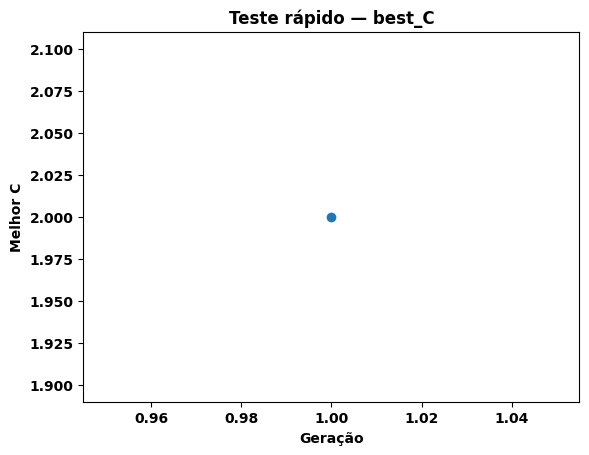

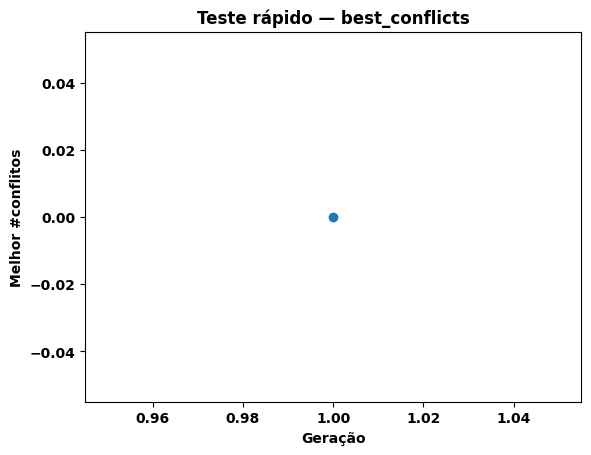

In [9]:
g_test = make_cycle_graph(10)
p_quick = PGAParams(pop_size=40, islands=3, max_generations=200, migration_interval=5, migration_size=3,
                    crossover="CEX", mutation="first_fit", mutation_prob=0.1, elitism=1)

out = run_pga(g_test, p_quick, target_colors=2, seed=123, verbose=False) #target_colors=None para ver uma curva(várias gerações)
out["solved_gen"], out["elapsed_s"], out["best_conflicts"], out["best_C"]

# %%
hist = out["history"]
plt.figure()
plt.plot(hist["gen"], hist["best_C"], marker="o")
plt.xlabel("Geração"); plt.ylabel("Melhor C"); plt.title("Teste rápido — best_C")
plt.show()

plt.figure()
plt.plot(hist["gen"], hist["best_conflicts"], marker="o")
plt.xlabel("Geração"); plt.ylabel("Melhor #conflitos"); plt.title("Teste rápido — best_conflicts")
plt.show()


In [10]:
out["solved_gen"], out["best_conflicts"], out["best_C"], out["history"].shape

(1, 0, 2, (1, 4))

6) Reprodução do experimento principal do artigo (Tabela 1)

O artigo usa as instâncias: anna, david, huck, miles500, myciel7, mulsol1 e reporta o ótimo (cores) para cada uma.


Loaded anna: n=138 m=493
Loaded david: n=87 m=406
Loaded huck: n=74 m=301
Loaded miles500: n=128 m=1170
Loaded myciel7: n=191 m=2360
Loaded mulsol1: n=197 m=3925


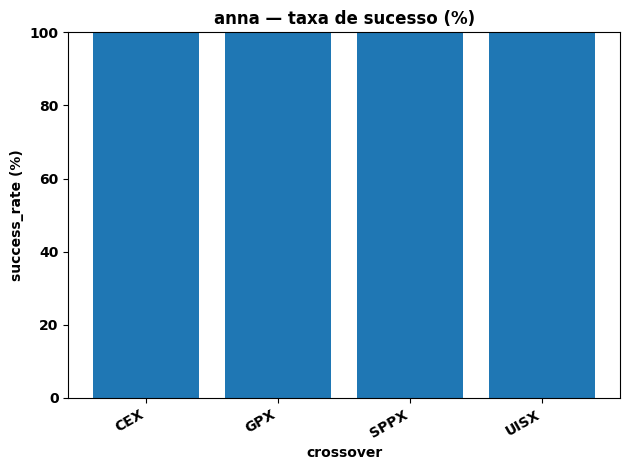

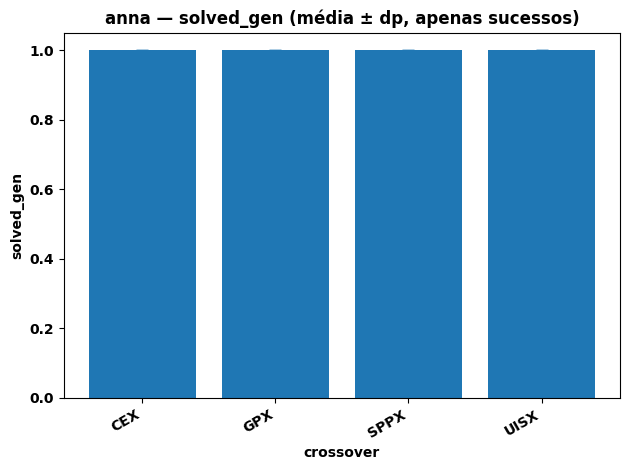

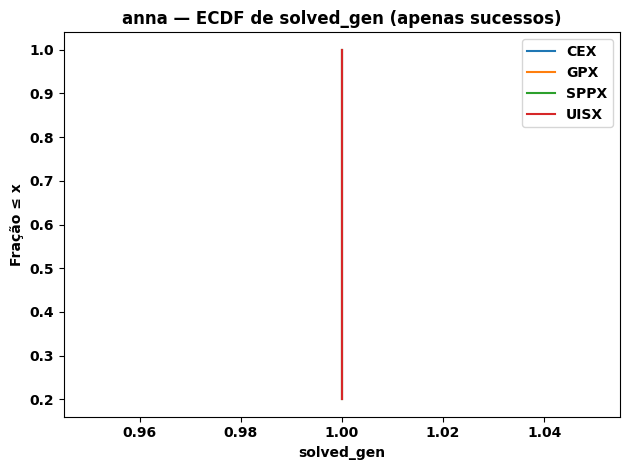

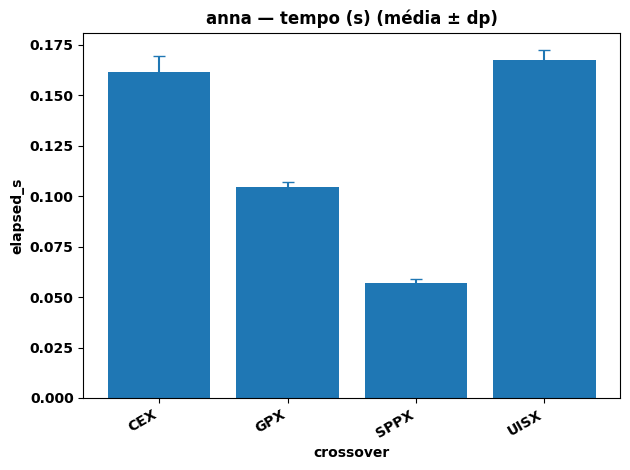

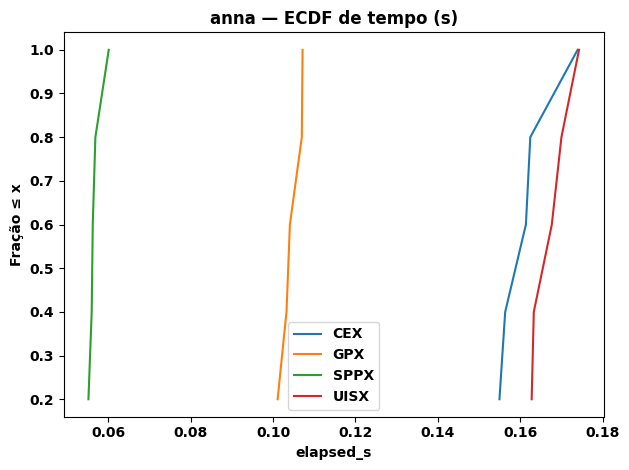

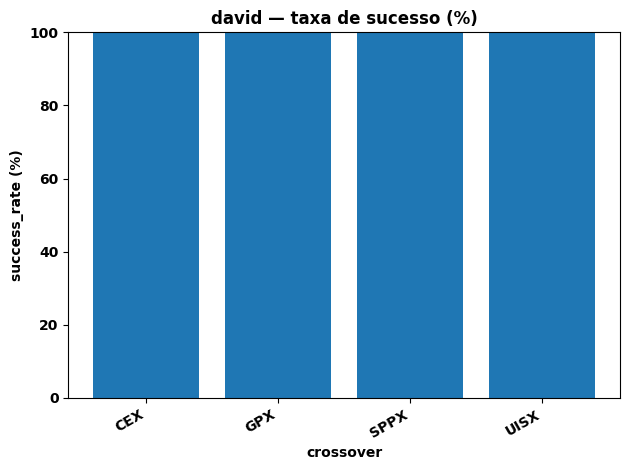

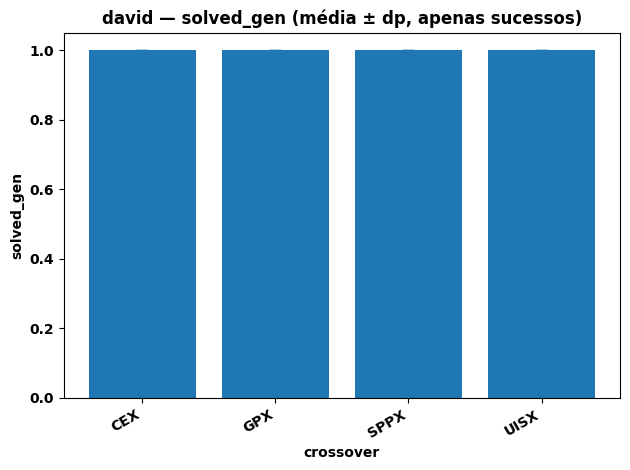

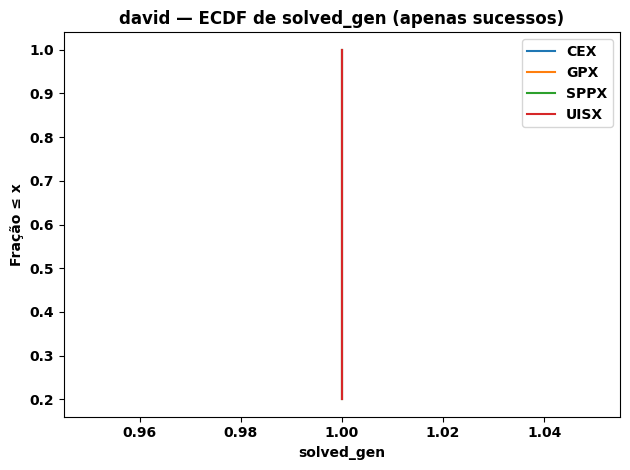

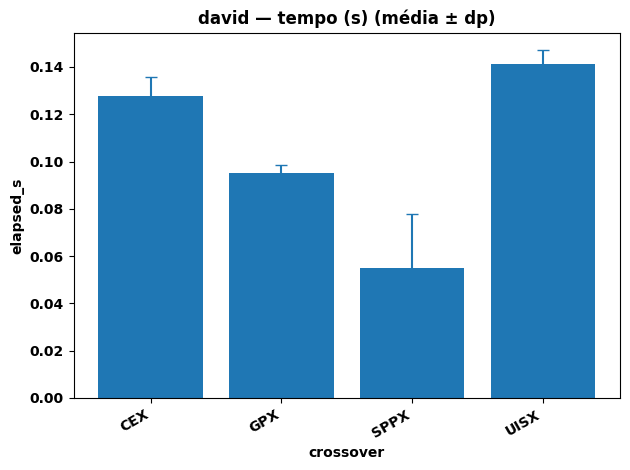

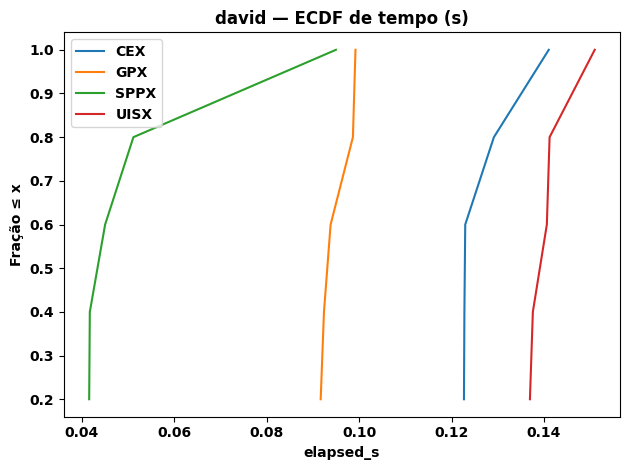

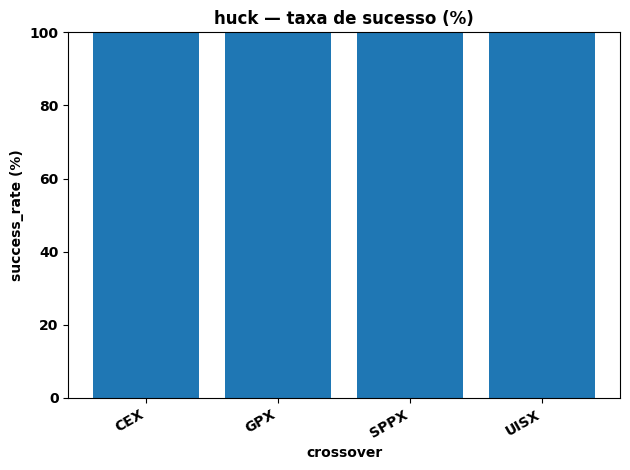

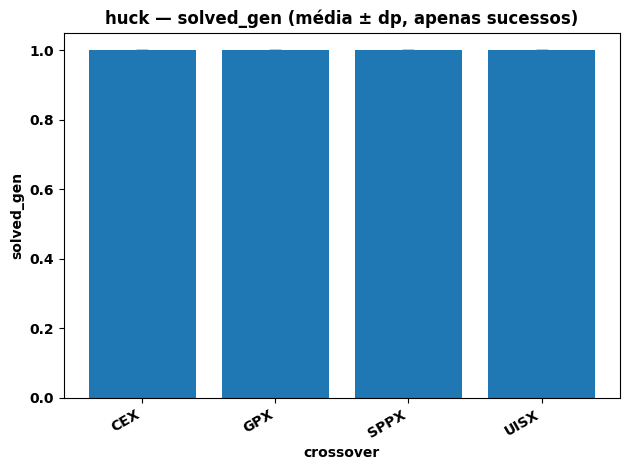

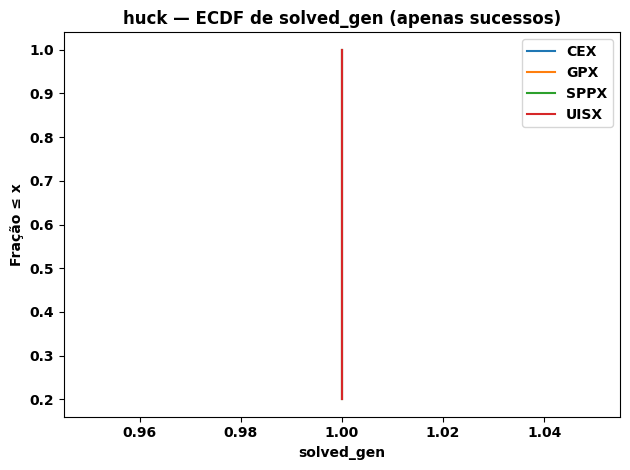

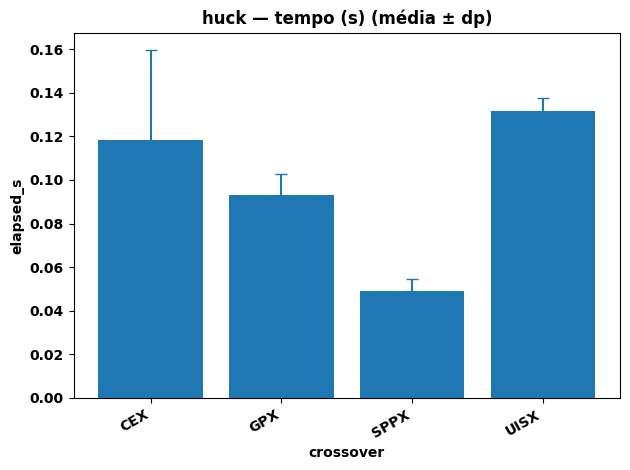

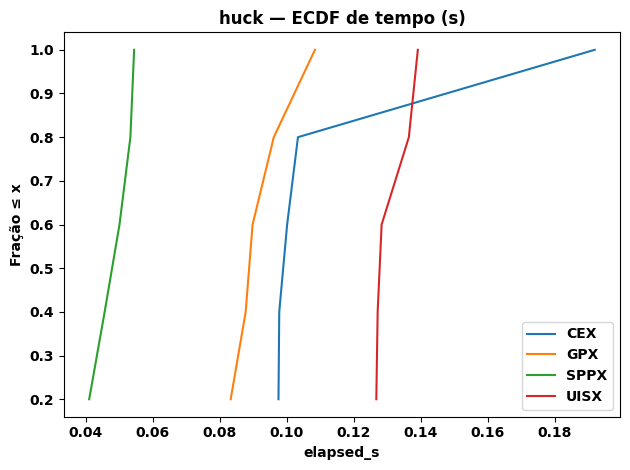

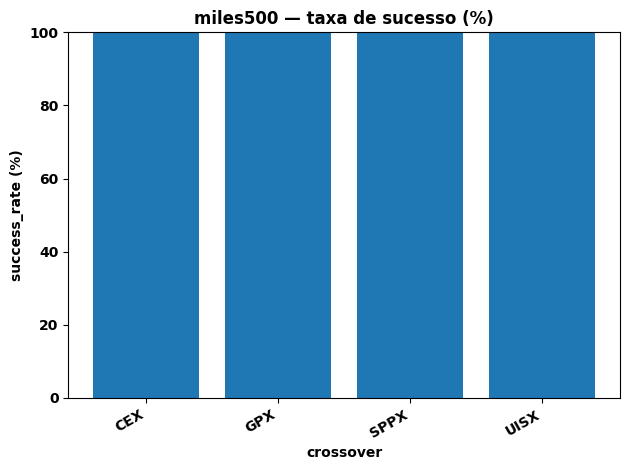

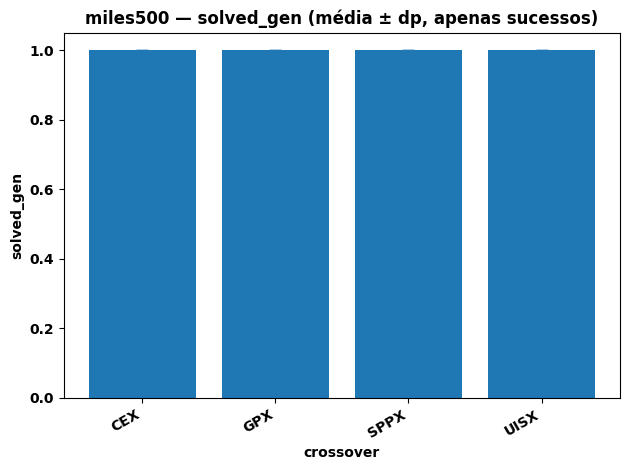

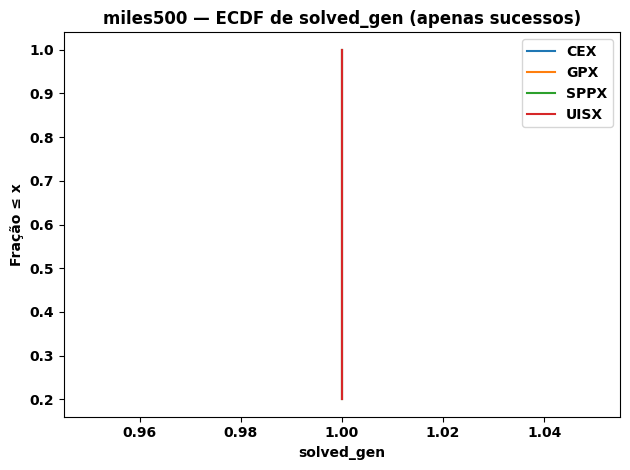

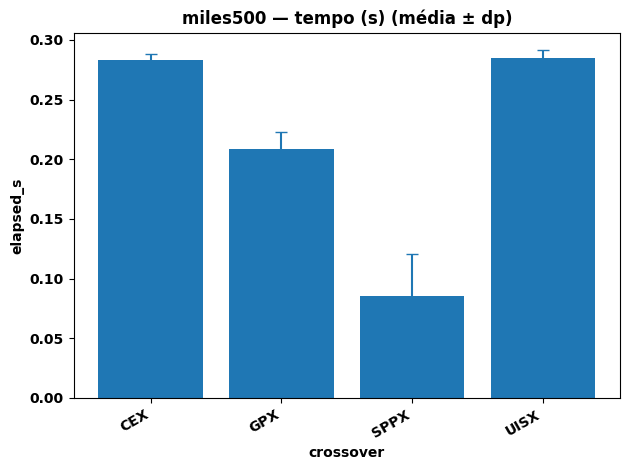

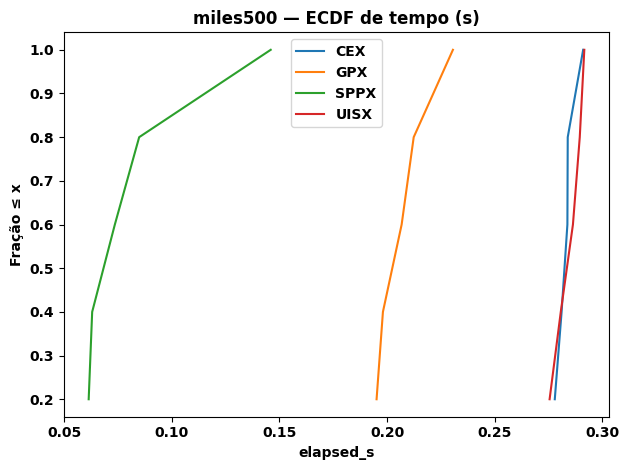

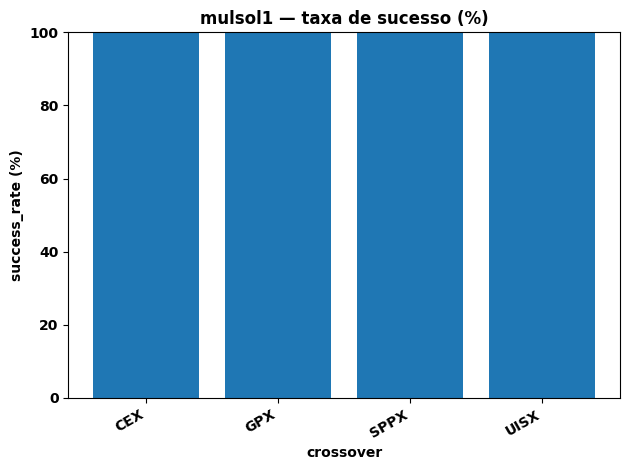

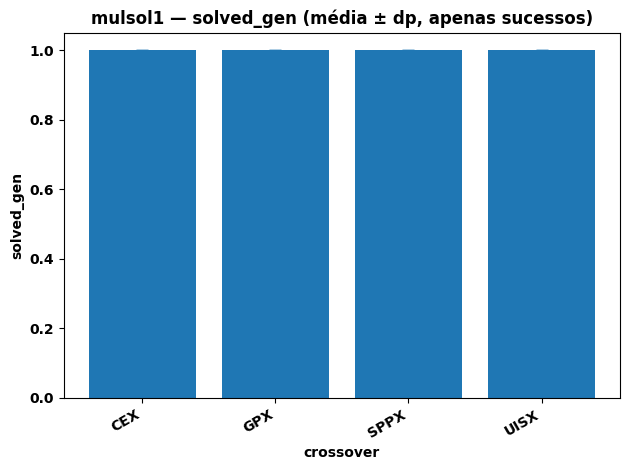

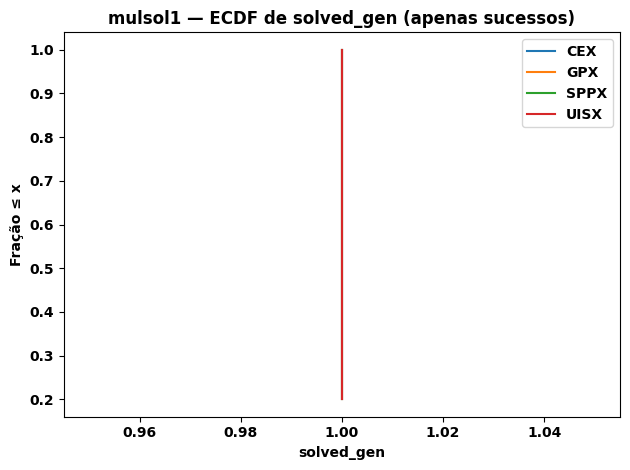

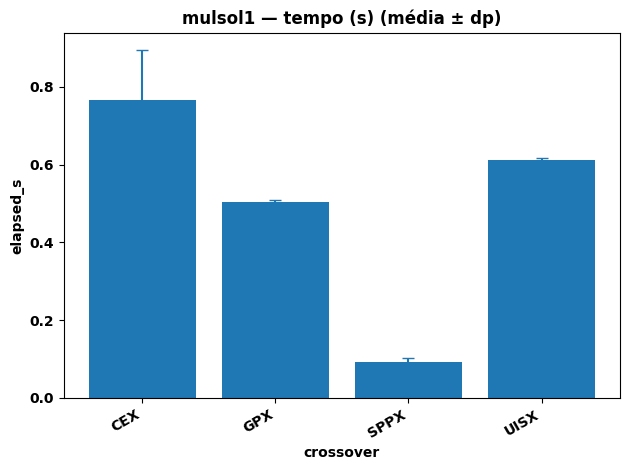

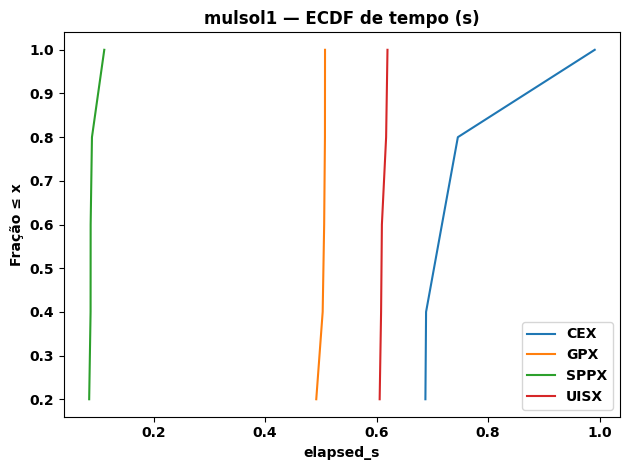

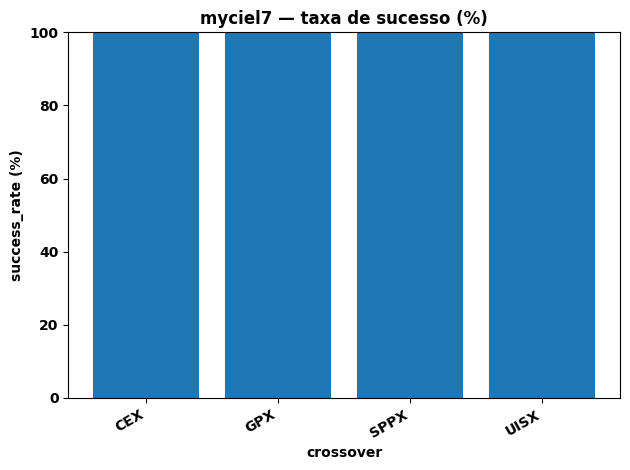

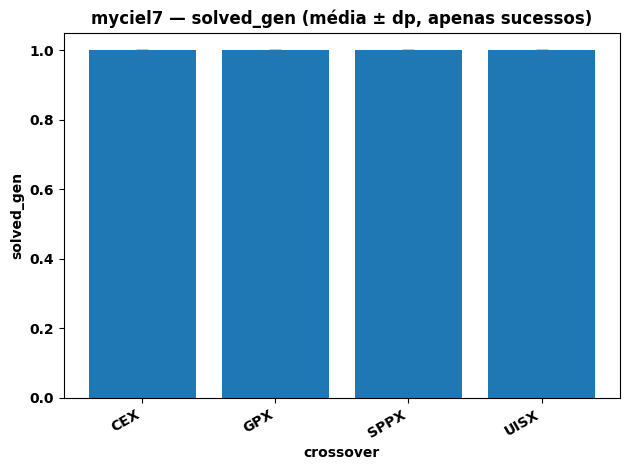

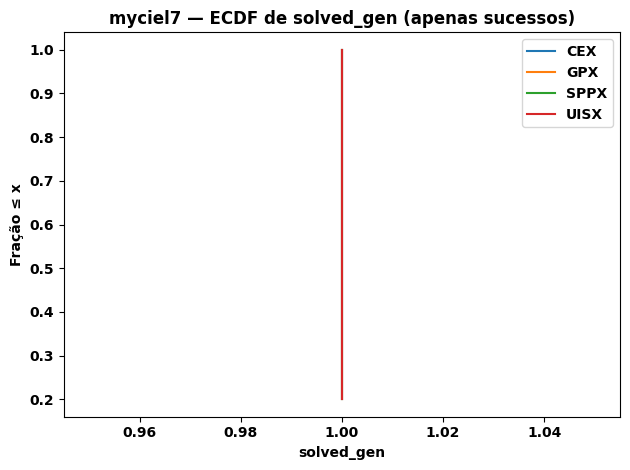

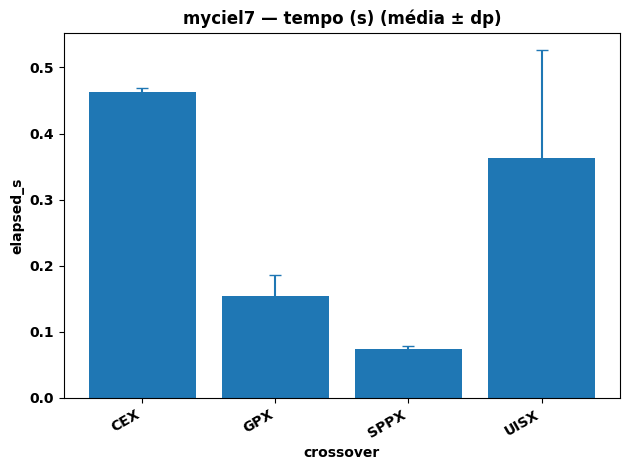

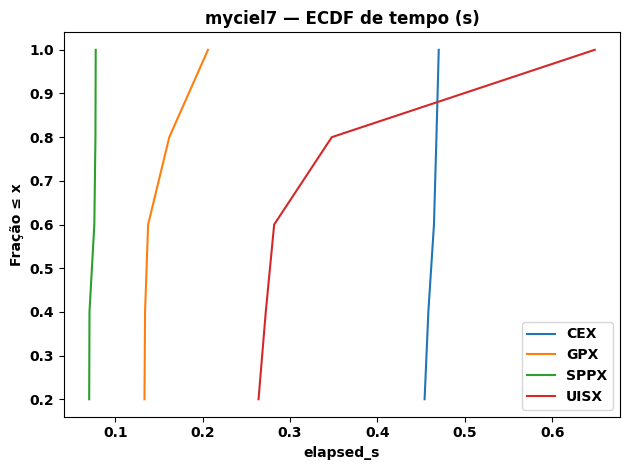

In [11]:
ARTICLE_TARGET_COLORS = {
    "anna": 11, "david": 11, "huck": 11, "miles500": 20, "myciel7": 8, "mulsol1": 49
}

INST_DIR = "./instances"
BENCH_FILES = {name: os.path.join(INST_DIR, f"{name}.col") for name in ARTICLE_TARGET_COLORS.keys()}

def load_benchmarks(files: Dict[str,str]) -> Dict[str,Graph]:
    out = {}
    for name,path in files.items():
        if os.path.exists(path):
            out[name] = read_dimacs_col(path)
            print(f"Loaded {name}: n={out[name].n} m={out[name].m}")
        else:
            print(f"[AVISO] faltando: {path}")
    return out

bench_graphs = load_benchmarks(BENCH_FILES)
bench_graphs.keys()

RUNS = 30     # troque para 30 quando estiver OK
MAX_GEN = 500

base = PGAParams(pop_size=60, islands=3, max_generations=MAX_GEN, migration_interval=5, migration_size=5,
                 migration_scheme="best", mutation="first_fit", mutation_prob=0.1, elitism=1)

CROSSOVERS = ["UISX","GPX","SPPX","CEX"]

rows = []
for gname,g in bench_graphs.items():
    target = ARTICLE_TARGET_COLORS[gname]
    for cx in CROSSOVERS:
        p = PGAParams(**{**base.__dict__, "crossover": cx})
        df = run_repeated(g, p, target, runs=RUNS, base_seed=1000)
        df["graph"] = gname
        df["target_colors"] = target
        rows.append(df)

df_main = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
df_main.head()

if len(df_main) > 0:
    summary = summarize_runs(df_main)
    summary[["graph","crossover","runs","success_rate","solved_gen_mean","solved_gen_std","elapsed_mean","elapsed_std"]].head(20)
else:
    print("Sem dados (faltam instâncias em ./instances/)")

if len(df_main) > 0:
    # Gráficos sugeridos: taxa de sucesso + barras (média±dp) + ECDF
    for gname in sorted(df_main["graph"].unique()):
        plot_crossover_suite(df_main, gname)


6.1 Tabela 1 do artigo (valores reportados) para comparação

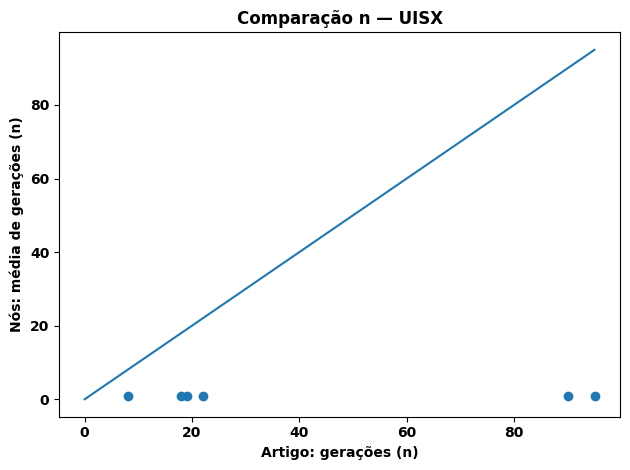

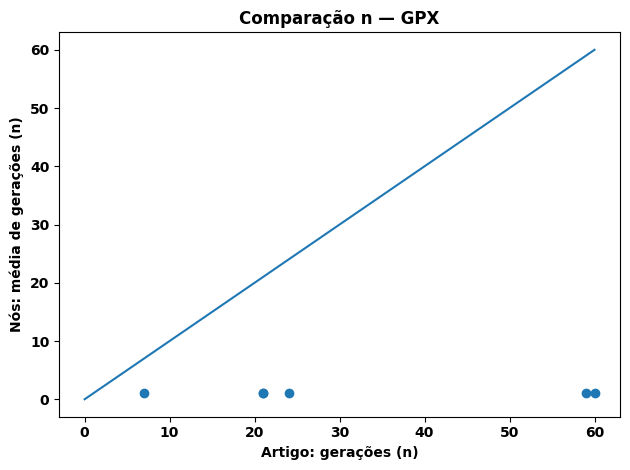

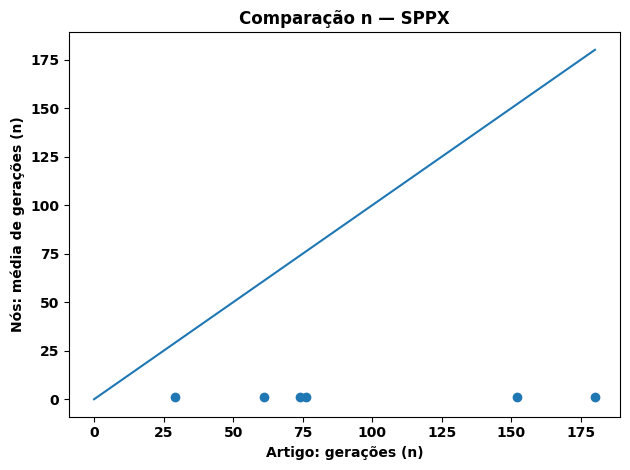

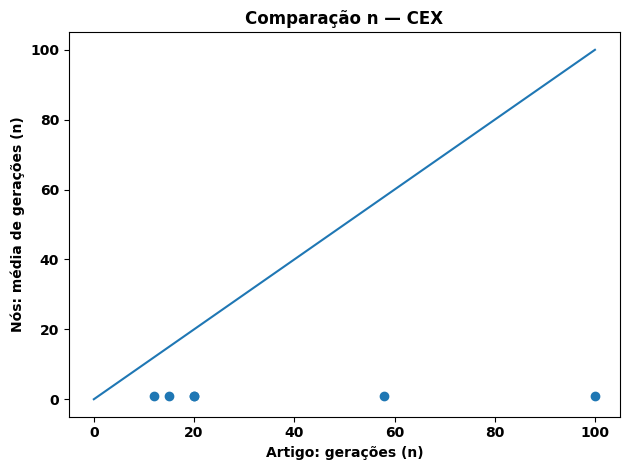

In [12]:
article_table1 = pd.DataFrame([
    ["anna", 138, 493, 11, 19, 2.0, 21, 6.0, 61, 3.2, 15, 1.3],
    ["david", 87, 406, 11, 22, 2.0, 24, 3.9, 74, 3.6, 20, 1.0],
    ["huck", 74, 301, 11, 8, 0.8, 7, 1.0, 29, 0.5, 12, 0.7],
    ["miles500", 128, 1170, 20, 95, 9.5, 59, 40.0, 152, 38.0, 100, 3.0],
    ["myciel7", 191, 2360, 8, 18, 2.0, 21, 7.9, 76, 7.6, 20, 1.0],
    ["mulsol1", 197, 3925, 49, 90, 31.0, 60, 35.0, 180, 34.0, 58, 2.0],
], columns=[
    "graph","vertices","edges","colors",
    "UISX_n","UISX_t",
    "GPX_n","GPX_t",
    "SPPX_n","SPPX_t",
    "CEX_n","CEX_t",
])
article_table1

# %%
if len(df_main) > 0:
    ours = summarize_runs(df_main)
    ours_small = ours[["graph","crossover","solved_gen_mean","elapsed_mean","success_rate"]].copy()
    ours_wide_n = ours_small.pivot(index="graph", columns="crossover", values="solved_gen_mean").add_suffix("_n_ours")
    ours_wide_t = ours_small.pivot(index="graph", columns="crossover", values="elapsed_mean").add_suffix("_t_ours")
    ours_wide_s = ours_small.pivot(index="graph", columns="crossover", values="success_rate").add_suffix("_success_%")

    comp = article_table1.set_index("graph").join([ours_wide_n, ours_wide_t, ours_wide_s])
    comp
else:
    print("Sem dados para comparação. Rode a seção 6 com instâncias carregadas.")

# %%
if len(df_main) > 0:
    comp2 = comp.reset_index()
    for cx in ["UISX","GPX","SPPX","CEX"]:
        ours_col = f"{cx}_n_ours"
        if ours_col not in comp2.columns:
            continue
        plt.figure()
        x = comp2[f"{cx}_n"].astype(float).values
        y = comp2[ours_col].astype(float).values
        plt.scatter(x, y)
        mx = np.nanmax(np.concatenate([x,y]))
        plt.plot([0,mx],[0,mx])
        plt.xlabel("Artigo: gerações (n)")
        plt.ylabel("Nós: média de gerações (n)")
        plt.title(f"Comparação n — {cx}")
        plt.tight_layout()
        plt.show()


7) Varredura de parâmetros (combinações) — requisito da disciplina
Você ajusta `PARAM_GRID` e escolhe um grafo.

In [ ]:
def grid_search(g: Graph, target_colors: Optional[int], base: PGAParams, grid: Dict[str,List[Any]], runs: int, base_seed: int=0) -> pd.DataFrame:
    keys = list(grid.keys())
    all_df = []
    for vals in itertools.product(*[grid[k] for k in keys]):
        d = {**base.__dict__}
        for k,v in zip(keys, vals):
            d[k] = v
        p = PGAParams(**d)
        df = run_repeated(g, p, target_colors, runs=runs, base_seed=base_seed)
        for k in keys:
            df[k] = getattr(p, k)
        all_df.append(df)
    return pd.concat(all_df, ignore_index=True) if all_df else pd.DataFrame()

PARAM_GRID = {
    "mutation_prob": [0.05, 0.1, 0.2],
    "migration_interval": [3, 5, 10],
    "migration_size": [2, 5],
}

RUNS_GRID = 30
GRID_GRAPH = "anna"

if GRID_GRAPH in bench_graphs:
    g = bench_graphs[GRID_GRAPH]
    target = ARTICLE_TARGET_COLORS[GRID_GRAPH]

    base_grid = PGAParams(**{**base.__dict__, "crossover":"CEX"})
    df_grid = grid_search(g, target, base_grid, PARAM_GRID, runs=RUNS_GRID, base_seed=5000)
    df_grid["graph"] = GRID_GRAPH

    grid_summary = summarize_runs(df_grid)
    grid_summary.head(20)
else:
    print("Grafo do grid não carregado. Verifique ./instances/")

# %%
# Visualização recomendada para grid search:
# - Heatmap 2D (mutation_prob × migration_interval), separando por migration_size
# - Métricas: taxa de sucesso (%) e solved_gen_mean (apenas sucessos)

if "df_grid" in globals() and "grid_summary" in globals() and len(df_grid) > 0:
    for ms in sorted(grid_summary["migration_size"].unique()):
        sub = grid_summary[grid_summary["migration_size"] == ms].copy()

        # Heatmap: taxa de sucesso
        piv_sr = sub.pivot(index="mutation_prob", columns="migration_interval", values="success_rate")
        heatmap_from_pivot(
            piv_sr,
            x_label="migration_interval",
            y_label="mutation_prob",
            value_label="success_rate (%)",
            title=f"{GRID_GRAPH} — Heatmap success_rate (%) | migration_size={ms}",
            annotate=True,
        )

        # Heatmap: gerações até ótimo (média, apenas sucessos; pode ficar NaN quando success_rate=0)
        piv_sg = sub.pivot(index="mutation_prob", columns="migration_interval", values="solved_gen_mean")
        heatmap_from_pivot(
            piv_sg,
            x_label="migration_interval",
            y_label="mutation_prob",
            value_label="solved_gen_mean",
            title=f"{GRID_GRAPH} — Heatmap solved_gen_mean | migration_size={ms}",
            annotate=True,
        )
else:
    print("Sem df_grid/grid_summary (execute a célula do grid_search acima).")
